In [350]:
from utils import *

import matplotlib.pyplot as plt
import seaborn as sb
from utils import *
import numpy as np
from copy import deepcopy

train_df = pd.read_pickle("../out/train.pkl")
test_df = pd.read_pickle("../out/test.pkl")

### Client count.
In both the training and test datasets, each account with a loan only has 1 or 2 clients. Therefore, for this analysis, it will be counted as binary

In [351]:
print("Encountered client count values in the training dataset:\n" + str(train_df["client_count_mean"].value_counts().index.to_list()) + " \nTesting dataset:\n" + str(test_df["client_count_mean"].value_counts().index.to_list()))

Encountered client count values in the training dataset:
[1.0, 2.0] 
Testing dataset:
[1.0, 2.0]


### Remove categoric data

In [352]:
train_df_analysis = deepcopy(train_df)

# # Removing ids
# del train_df_analysis["loan_id"]
# Removing categoric variables
del train_df_analysis["status"]
#del train_df_analysis["sex"]
del train_df_analysis["num_times_under_zero"]

del train_df_analysis["issuance_frequency_per_month"]
# Also counts as categoric data for this analysis
del train_df_analysis["client_count_mean"]


### Plot Value distributions

### Histogram

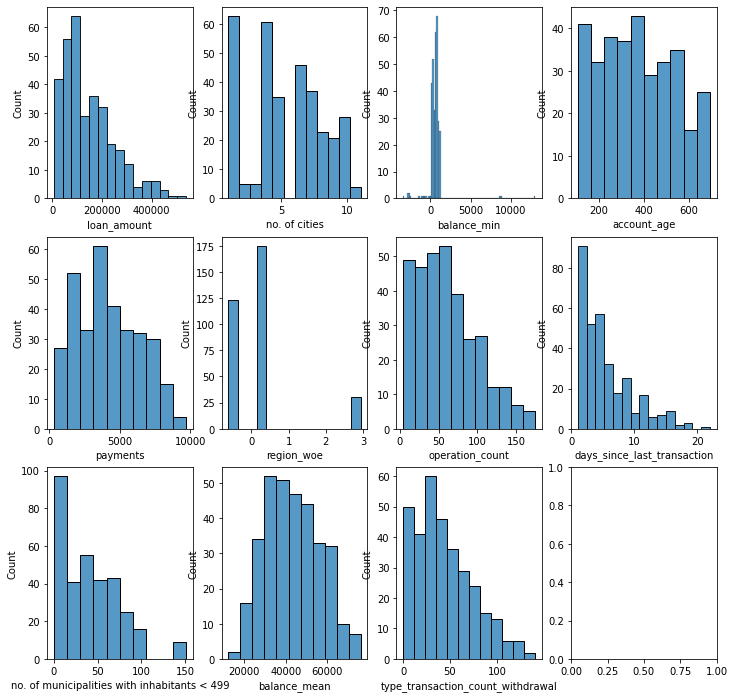

In [353]:
nrows = 3
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12, 12])
i = 0
for col_name in train_df_analysis:
    if(col_name != "loan_id"):
        axs = sb.histplot(data=train_df_analysis, x=train_df_analysis[col_name], ax=ax[(int(i)%nrows), (int(i)//nrows)])
        i = i + 1

plt.show()

Variables that may have outliers from looking at the histogram (by descending order of likelihood): 
balance_min, 
no. of municipalities with inhabitants < 499, 
days_since_last_transaction

### Boxplot

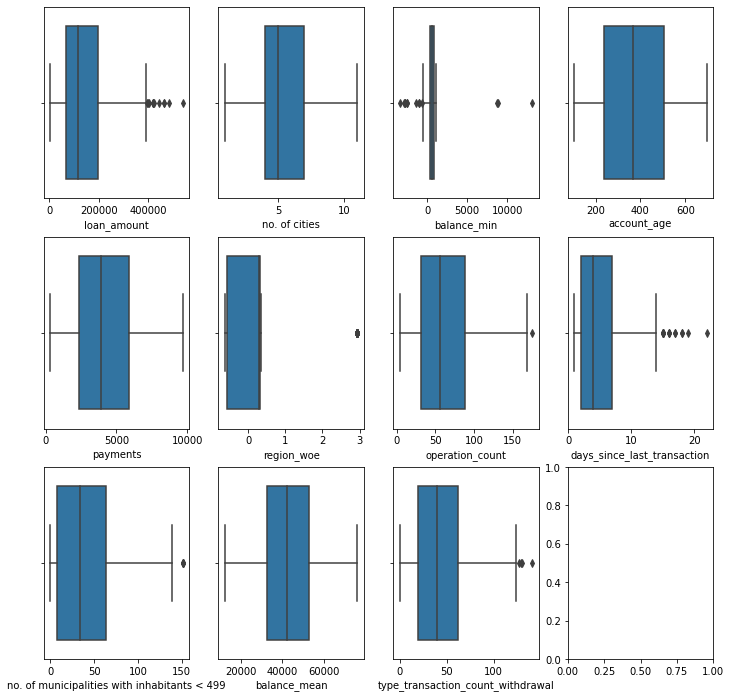

In [354]:
nrows = 3
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12, 12])
i = 0
for col_name in train_df_analysis:
    if(col_name != "loan_id"):
        axs = sb.boxplot(data=train_df_analysis, x=train_df_analysis[col_name], ax=ax[(int(i)%nrows), (int(i)//nrows)])
        i = i + 1

plt.show()

Variables that may have outliers from looking at the boxplot (by descending order of likelihood): 
loan_amount, 
operation_count, 
days_since_last_transaction, 
no. of municipalities with inhabitants < 499, 
balance_min

### Using coeficients of variation to compare each variable's deviation.

In [355]:
coeficients_of_variation = {}
standard_deviations = {}
means = {}
# Calculate coeficients of variation (standard variation / mean * 100[%])
for col_name in train_df_analysis:
    coeficients_of_variation[col_name] = np.std(train_df_analysis[col_name])
    standard_deviations[col_name] = coeficients_of_variation[col_name]
    means[col_name] = np.average(train_df_analysis[col_name])
    coeficients_of_variation[col_name] /= means[col_name] / 100
coeficients_of_variation

{'loan_id': 10.74771714624751,
 'loan_amount': 72.31969874170875,
 'payments': 52.765836983908116,
 'no. of municipalities with inhabitants < 499': 85.97373822506141,
 'no. of cities': 53.96585980480534,
 'region_woe': 430.28042646343005,
 'balance_mean': 30.62898618069096,
 'balance_min': 175.24641537998872,
 'operation_count': 63.263362313946985,
 'type_transaction_count_withdrawal': 70.05735095406341,
 'account_age': 43.695686135425866,
 'days_since_last_transaction': 77.38193866770357}

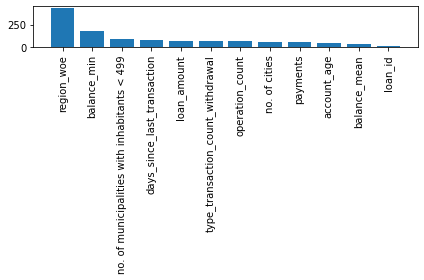

In [356]:
# Barplot of coeficients of variation
coeficients_of_variation_sorted = dict(sorted(coeficients_of_variation.items(), key=lambda item: -item[1]))

num_items = len(coeficients_of_variation_sorted.items())
plt.bar(np.arange(num_items), coeficients_of_variation_sorted.values())
plt.xticks(np.arange(num_items), coeficients_of_variation_sorted.keys(), rotation=90)
plt.tight_layout()
plt.show()

## Outliar detection methods
### Standard deviation method

In [357]:
# Using 2-3 is normal for datasets of this size. This will not work for certain data, such as region data, since it has less values. For those, we will use the quartile method.
std_multiplier = 3
labels = train_df_analysis.columns.difference(train_df.columns.difference(["loan_amount", "operation_count", "type_transaction_count_withdrawal", "days_since_last_transaction"]))
train_df_std_method = train_df#train_df_analysis.drop( axis=1, labels=train_df_analysis.columns.difference(["loan_amount", "operation_count", "type_transaction_count_withdrawal", "no. of municipalities with inhabitants < 499", "days_since_last_transaction"]))
outliers = {}
for col_name in labels:
    low_bound, high_bound = means[col_name] - (standard_deviations[col_name] * std_multiplier), means[col_name] + (standard_deviations[col_name] * std_multiplier)
    outliers[col_name] = train_df.loc[(train_df[col_name] < low_bound) | (train_df[col_name] > high_bound)]
    #print("Name: " + str(col_name) + " Count: " + str(outliers[col_name].count()) + "Head10: " + str(outliers[col_name].head(10)))

for col_name in outliers:
    if(outliers[col_name].any(axis=None)):
        print("Name = " + col_name + ":")
        display(outliers[col_name])
        print("Std: " + str(standard_deviations[col_name]))
        print("Quartile 75s: \n")
        for col_name in train_df_analysis:
            print(str(col_name) + " = " + str(train_df[col_name].quantile(.75)))

Name = days_since_last_transaction:


,loan_id,loan_amount,payments,issuance_frequency_per_month,no. of municipalities with inhabitants < 499,no. of cities,region_woe,balance_mean,balance_min,client_count_mean,operation_count,type_transaction_count_withdrawal,num_times_under_zero,account_age,days_since_last_transaction,status
1,4961,30276,2523,1.0,87,7,-0.502458,25197.092500,715.0,1.0,56,34,False,388,19,-1
23,5161,98184,4091,1.0,101,4,0.334202,41660.392857,500.0,1.0,8,3,False,111,18,1
196,6501,30276,2523,1.0,87,7,-0.502458,31318.872826,1000.0,1.0,56,34,False,388,18,-1
246,6738,230220,6395,1.0,0,1,-0.578586,27658.487805,-2719.7,1.0,61,44,True,356,22,-1


Std: 4.166356819730625
Quartile 75s: 

loan_id = 6737.25
loan_amount = 198600.0
payments = 5907.75
no. of municipalities with inhabitants < 499 = 63.5
no. of cities = 7.0
region_woe = 0.3342023734395152
balance_mean = 53012.5848642534
balance_min = 900.0
operation_count = 89.0
type_transaction_count_withdrawal = 62.25
account_age = 503.25
days_since_last_transaction = 7.0
Name = loan_amount:


,loan_id,loan_amount,payments,issuance_frequency_per_month,no. of municipalities with inhabitants < 499,no. of cities,region_woe,balance_mean,balance_min,client_count_mean,operation_count,type_transaction_count_withdrawal,num_times_under_zero,account_age,days_since_last_transaction,status
16,5132,538500,8975,1.000000,65,6,0.299436,33687.858621,200.0,1.0,48,36,False,336,3,1
119,5970,465072,9689,1.000000,151,5,0.334202,27778.745631,300.0,2.0,86,65,True,541,1,1
164,6228,464520,7742,4.348214,8,4,-0.578586,51760.016176,200.0,1.0,59,37,False,257,1,-1
301,7142,482940,8049,1.000000,0,1,-0.618649,26358.754615,900.0,1.0,100,74,True,477,6,-1


Std: 105086.75764085042
Quartile 75s: 

loan_id = 6737.25
loan_amount = 198600.0
payments = 5907.75
no. of municipalities with inhabitants < 499 = 63.5
no. of cities = 7.0
region_woe = 0.3342023734395152
balance_mean = 53012.5848642534
balance_min = 900.0
operation_count = 89.0
type_transaction_count_withdrawal = 62.25
account_age = 503.25
days_since_last_transaction = 7.0
Name = type_transaction_count_withdrawal:


,loan_id,loan_amount,payments,issuance_frequency_per_month,no. of municipalities with inhabitants < 499,no. of cities,region_woe,balance_mean,balance_min,client_count_mean,operation_count,type_transaction_count_withdrawal,num_times_under_zero,account_age,days_since_last_transaction,status
36,5311,30060,501,1.0,66,8,0.253406,37213.407527,500.0,1.0,165,141,False,651,2,1


Std: 31.0089213765577
Quartile 75s: 

loan_id = 6737.25
loan_amount = 198600.0
payments = 5907.75
no. of municipalities with inhabitants < 499 = 63.5
no. of cities = 7.0
region_woe = 0.3342023734395152
balance_mean = 53012.5848642534
balance_min = 900.0
operation_count = 89.0
type_transaction_count_withdrawal = 62.25
account_age = 503.25
days_since_last_transaction = 7.0


### Using first/third quartile method

In [358]:
# Using 2-3 is normal for datasets of this size. This will not work for certain data, such as region data, since it has less values. For those, we will use the quartile method.
iqr_multiplier = 1.5
labels = train_df_analysis.columns.difference(train_df.columns.difference(["no. of municipalities with inhabitants < 499","region_woe"]))
train_df_iqr_method = train_df
outliers = {}
for col_name in labels:
    q1, q3 = train_df_iqr_method[col_name].quantile(.25), train_df_iqr_method[col_name].quantile(.75)
    iqr = q3 - q1
    low_bound, high_bound = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr
    outliers[col_name] = train_df.loc[(train_df[col_name] < low_bound) | (train_df[col_name] > high_bound)]

for col_name in outliers:
    if(outliers[col_name].any(axis=None)):
        print("Name = " + col_name + ":")
        display(outliers[col_name])
        print("Quartile 75s: \n")
        for col_name in train_df_analysis:
            print(str(col_name) + " = " + str(train_df[col_name].quantile(.75)))


Name = no. of municipalities with inhabitants < 499:


,loan_id,loan_amount,payments,issuance_frequency_per_month,no. of municipalities with inhabitants < 499,no. of cities,region_woe,balance_mean,balance_min,client_count_mean,operation_count,type_transaction_count_withdrawal,num_times_under_zero,account_age,days_since_last_transaction,status
4,5002,104808,8734,1.0,151,5,0.334202,38709.830000,500.0,2.0,25,18,False,186,6,1
102,5836,79632,3318,1.0,151,5,0.334202,63494.200000,900.0,1.0,12,6,False,141,14,1
119,5970,465072,9689,1.0,151,5,0.334202,27778.745631,300.0,2.0,86,65,True,541,1,1
143,6109,368880,6148,1.0,151,5,0.334202,60030.743407,1100.0,2.0,162,124,False,590,3,1
299,7137,151560,6315,1.0,151,5,0.334202,53976.292857,300.0,1.0,22,15,False,194,2,1


Quartile 75s: 

loan_id = 6737.25
loan_amount = 198600.0
payments = 5907.75
no. of municipalities with inhabitants < 499 = 63.5
no. of cities = 7.0
region_woe = 0.3342023734395152
balance_mean = 53012.5848642534
balance_min = 900.0
operation_count = 89.0
type_transaction_count_withdrawal = 62.25
account_age = 503.25
days_since_last_transaction = 7.0
Name = region_woe:


,loan_id,loan_amount,payments,issuance_frequency_per_month,no. of municipalities with inhabitants < 499,no. of cities,region_woe,balance_mean,balance_min,client_count_mean,operation_count,type_transaction_count_withdrawal,num_times_under_zero,account_age,days_since_last_transaction,status
3,4996,88440,7370,13.044643,9,8,2.938585,62778.090323,200.0,2.0,25,15,False,179,6,1
10,5088,91152,3798,1.000000,32,10,2.938585,44829.544156,400.0,1.0,63,46,False,465,3,1
11,5125,73056,1522,1.000000,17,4,2.938585,23255.149020,500.0,2.0,42,28,False,290,11,1
15,5131,48624,2026,1.000000,9,8,2.938585,63857.236752,200.0,1.0,100,68,False,521,1,1
20,5148,284280,4738,1.000000,71,9,2.938585,64182.641489,300.0,2.0,77,58,False,561,17,1
29,5212,71064,1974,1.000000,41,4,2.938585,34577.302326,700.0,1.0,74,57,False,403,13,1
43,5337,162468,4513,1.000000,32,10,2.938585,51279.553333,700.0,2.0,11,5,False,148,15,1
55,5414,185952,3874,1.000000,28,5,2.938585,50113.194118,700.0,1.0,24,14,False,375,4,1
59,5445,46320,1930,1.000000,24,11,2.938585,43657.813483,900.0,1.0,161,130,False,544,4,1
83,5610,123216,2567,1.000000,41,4,2.938585,70622.833594,700.0,2.0,110,80,False,561,2,1


Quartile 75s: 

loan_id = 6737.25
loan_amount = 198600.0
payments = 5907.75
no. of municipalities with inhabitants < 499 = 63.5
no. of cities = 7.0
region_woe = 0.3342023734395152
balance_mean = 53012.5848642534
balance_min = 900.0
operation_count = 89.0
type_transaction_count_withdrawal = 62.25
account_age = 503.25
days_since_last_transaction = 7.0
